In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import tools

In [3]:
# plt.style.use("coolbeans")
sns.set_style("whitegrid")
np.random.seed(123)

In [4]:
DB_PATH = "./data/stationdb.sqlite"
ERAI_PATH = "./data/erai.npz"
OISST_PATH = "./data/oisst.npz"
WATER_YEAR = {"low": 1983,
              "high": 2012}
WY_RANGE = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}
WESTOFLON = -104
EASTOFLON = -125
MC_NRUNS = 500

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
# sql_query = "SELECT stationid, wy, avg(mean) FROM StationMonthly WHERE wy <= {wy_high} AND wy >= {wy_low} AND stationid IN ({seq}) GROUP BY stationid, wy ORDER BY stationid, wy ASC".format(wy_low = str(WATER_YEAR["low"]), wy_high = str(WATER_YEAR["high"]), seq = ",".join(["?"] * len(target_stations)))
sql_query = "SELECT stationid, year, mean FROM StationWY WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) GROUP BY stationid, year ORDER BY stationid, year ASC".format(wy_low = str(WATER_YEAR["low"]), wy_high = str(WATER_YEAR["high"]), seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["year", "stationid"])
conn.close()

In [6]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, latgage, longage FROM StationInfo WHERE stationid IN ({seq}) ORDER BY stationid ASC".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

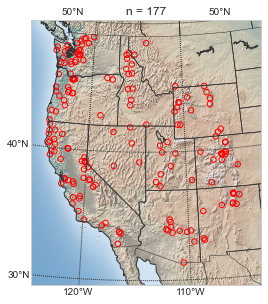

In [7]:
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## Mapped SSI linear trend

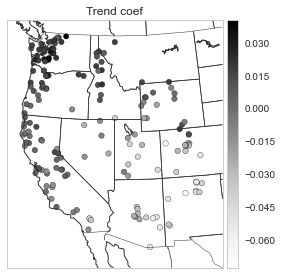

In [8]:
# Parse and shape the data we grabbed. Standardize it. Grad trend coefficients.
parsed = raw.groupby(level = "stationid")["mean"].transform(tools.spigamma)

trend_coefs = parsed.groupby(level = "stationid").apply(tools.trender)
# Detrending. Let's see what happens.
# parsed = parsed.groupby(level = "stationid").transform(signal.detrend)
# parsed = parsed.unstack()

# Map trend coefs.
out = tools.plot_trendmap(trend_coefs, latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## Basic North Test scree plot

In [9]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 6
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

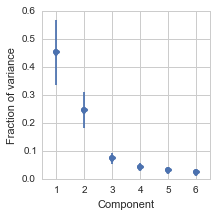

In [10]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [11]:
retain_modes = 2

## PC time series from leading components

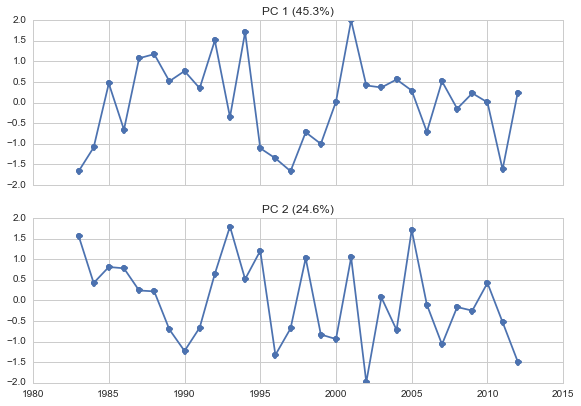

In [12]:
out = tools.plot_pc(solver, yr = WY_RANGE, nmodes = retain_modes)

## Leading EOFs mapped as covariance

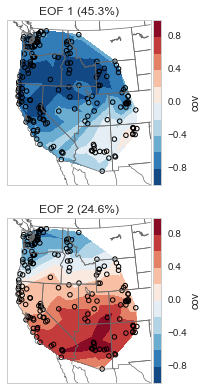

In [13]:
out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes)

## Leading two modes as vectors

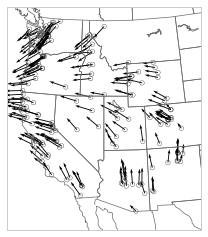

In [14]:
# Linear regression of the first two leading PCs onto the gage time series to get regression coefficients.
rcoef1 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])

out = tools.plot_vectormap(coef1 = rcoef1, coef2 = rcoef2,
                           lat = latlon["latgage"].as_matrix(),
                           lon = latlon["longage"].as_matrix())

# Point correlation maps

## Northern hemisphere NDJ 500 mb geopotential height

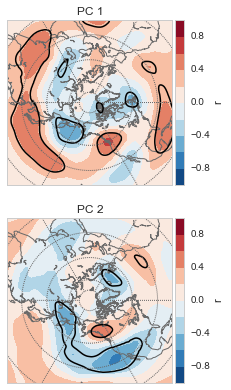

In [15]:
erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= WATER_YEAR["low"]) & (erai["time"] <= WATER_YEAR["high"])
hgts = erai["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts, 
                         lat = erai["lat"], lon = erai["lon"], 
                         nmodes = retain_modes)

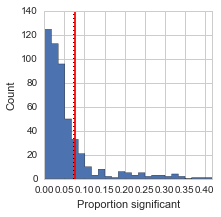

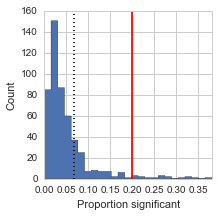

In [16]:
for i in range(retain_modes):
    noise_distribution, star = tools.pearson_fieldsig_test(pc[:, i], hgts.copy(), erai["lat"], local_alpha = 0.05, nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

## Detrended NDJ global SST

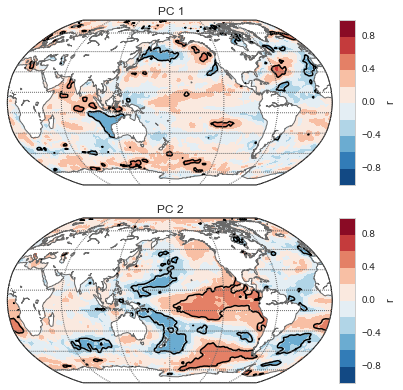

In [17]:
# Correlate PCs with OI SST data (NDJ mean) detrended anomalies.

oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= WATER_YEAR["low"]) & (oisst["time"] <= WATER_YEAR["high"])
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, 
                         lat = oisst["lat"], lon = oisst["lon"], 
                         nmodes = retain_modes, 
                         msk = oisst["landmask"], world_map = True)

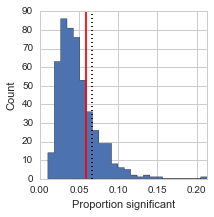

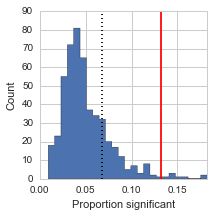

In [18]:
for i in range(retain_modes):
    noise_distribution, star = tools.pearson_fieldsig_test(pc[:, i], sst.copy(), 
                                                           oisst["lat"], 
                                                           local_alpha = 0.05, 
                                                           nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

# Composite maps

## Below is a crazy experiment with aggregating gage series

In [19]:
# ## less_ts = parsed.groupby(level = "year").aggregate(lambda x: np.sum(x < -1.3)/len(x))
# abs_thresh = 1.75
# test = pd.DataFrame()
# test["dry"] = parsed.groupby(level = "year").aggregate(lambda x: np.sum(x < -abs_thresh)/len(x))
# test["wet"] = parsed.groupby(level = "year").aggregate(lambda x: np.sum(x > abs_thresh)/len(x))
# test.plot(kind = "bar", stacked = False)
# plt.show()

In [20]:
# quarts = pd.qcut(pc[:, 0], [0, 0.5, 1], labels = ["low", "high"])
# ## quarts = pd.qcut(pc[:, 0], [0, 0.3, 0.6, 1], labels = ["low", "mid", "high"])
# print(wy_range[(quarts == "high")])
# ## parsed.groupby(level = "stationid").aggregate
# high_mean = parsed.iloc[parsed.index.isin(wy_range[(quarts == "high")], level = 0)].groupby(level = "stationid").aggregate(np.mean)
# low_mean = parsed.iloc[parsed.index.isin(wy_range[(quarts == "low")], level = 0)].groupby(level = "stationid").aggregate(np.mean)
# tools.plot_trendmap(high_mean, latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())
# tools.plot_trendmap(low_mean, latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())
# plt.show()
# ## high_mean.plot(kind = "kde")
# ## low_mean.plot(kind = "kde")
# parsed.iloc[parsed.index.isin(wy_range[(quarts == "high")], level = 0)].plot(kind = "kde")
# parsed.iloc[parsed.index.isin(wy_range[(quarts == "low")], level = 0)].plot(kind = "kde")
# ## plt.legend()

## Northern hemisphere NDJ 500 mb geopotential height

In [21]:
# Composite map of NDJ mean 500 mb height anomalies.
erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= WATER_YEAR["low"]) & (erai["time"] <= WATER_YEAR["high"])
hgts = erai["data"][0, 1, msk_time]

In [22]:

# for i in range(retain_modes):
#     out = tools.plot_many_hgt_composites(pc[:, i], wy_range, 
#                                          field = hgts, 
#                                          lat = erai["lat"], lon = erai["lon"])

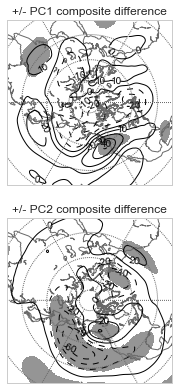

In [23]:
erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= WATER_YEAR["low"]) & (erai["time"] <= WATER_YEAR["high"])
hgts = erai["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_ttest(solver, hgts, 
                       lat = erai["lat"], lon = erai["lon"], 
                       nmodes = retain_modes, alpha = 0.05)

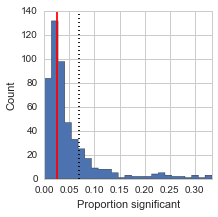

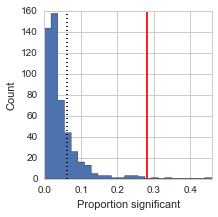

In [24]:
for i in range(retain_modes):
    noise_distribution, star = tools.ttest_fieldsig_test(pc[:, i], hgts.copy(), 
                                                         erai["lat"], 
                                                         local_alpha = 0.05, 
                                                         nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)

## Detrended NDJ global SST

In [25]:
oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= WATER_YEAR["low"]) & (oisst["time"] <= WATER_YEAR["high"])
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)

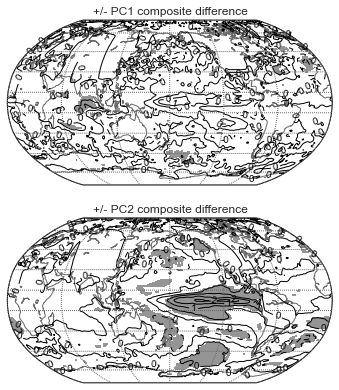

In [26]:
out = tools.plot_ttest(solver, sst, 
                         lat = oisst["lat"], lon = oisst["lon"], 
                         nmodes = retain_modes, 
                         msk = oisst["landmask"], world_map = True)

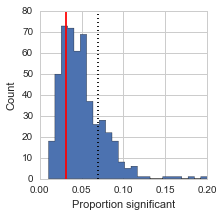

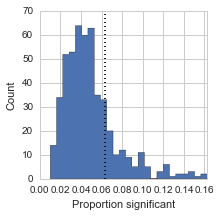

In [27]:
for i in range(retain_modes):
    noise_distribution, star = tools.ttest_fieldsig_test(pc[:, i], sst.copy(), oisst["lat"], local_alpha = 0.05, nruns = MC_NRUNS)
    noise_distribution.sort()
    p = tools.plot_fieldsig(noise_distribution, star)